In [38]:
import pickle
import torch
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
import sys
sys.path.append("../../..")
from datasets.morpho_mnist.dataset import ImageDataset, MetadataDataset, TripletDataset
from auto_localization.models.BasicVAE import BasicVAE
from auto_localization.experiment_management.basic_experiment import BasicExperiment
from auto_localization.dataset_management.data_manager import DataManager
from auto_localization.plotting.localization import save_localization_metadata_distance_plots
from auto_localization.oracles.metadata_oracle import MetadataOracle
from auto_localization.oracles.indexed_metadata_oracle import IndexedMetadataOracle
from datasets.morpho_mnist.measure import measure_image
from auto_localization.localization.localization_experiment_manager import LocalizationExperimentManager
from auto_localization.plotting.localization import embedding_with_posterior_path, embedding_with_planes
import auto_localization.plotting.localization as localization_plotting
import auto_localization.plotting.image_sampling as image_sampling

In [39]:
with_triplets = "../../logs/polar-dragon-1239"
without_triplets = "../../logs/crisp-plasma-1238"

In [40]:
def load_objects(model_dir):
    # load localizers
    with open(model_dir+"/localizers.pkl", "rb") as f:
        localizers = pickle.load(f)
    # load metrics
    with open(model_dir+"/localizer_metrics.pkl", "rb") as f:
        localizer_metrics = pickle.load(f)
    # load config 
    with open(model_dir+"/params.pkl", "rb") as f:
        config = pickle.load(f)
    print(config)
    # load model
    model_path = model_dir+"/model.pkl"
    z_dim = config["model_config"]["latent_dim"]
    in_shape = config["model_config"]["in_shape"]
    d = config["model_config"]["d"]
    layer_count = config["model_config"]["layer_count"]
    channels = config["model_config"]["channels"]
    model = BasicVAE(z_dim = z_dim, in_shape = in_shape, d = d, layer_count=layer_count, channels=channels)
    model.load_state_dict(torch.load(model_path))
    model.to("cuda")
    model.eval()
        
    return localizers, localizer_metrics, model, config

In [5]:
triplet_localizers, triplet_localizer_metrics, triplet_model, triplet_config = load_objects(with_triplets)
no_triplet_localizers, no_triplet_localizer_metrics, no_triplet_model, no_triplet_config = load_objects(without_triplets)

{'trials': 1, 'epochs': 100, 'lr': 0.001, 'batch_size': 128, 'trainer': 'triplet', 'localization_config': {'indexed': False, 'trials': 20, 'k': 0.5, 'localizer_type': 'MCMV', 'num_queries': 20}, 'model_config': {'model_type': 'BasicVAE', 'latent_dim': 6, 'in_shape': 32, 'd': 32, 'layer_count': 4, 'channels': 1, 'loss_name': 'VAETripletLoss', 'kl_beta': 0.001, 'triplet_beta': 0.1, 'triplet_margin': 1.0, 'warm_start': 100, 'kl_max': 0.001, 'triplet_mining': False}, 'dataset_config': {'component_weighting': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'which_digits': [1], 'one_two_ratio': 0.0}}
{'trials': 1, 'epochs': 100, 'lr': 0.001, 'batch_size': 128, 'trainer': 'triplet', 'localization_config': {'indexed': False, 'trials': 20, 'k': 0.5, 'localizer_type': 'MCMV', 'num_queries': 20}, 'model_config': {'model_type': 'BasicVAE', 'latent_dim': 6, 'in_shape': 32, 'd': 32, 'layer_count': 4, 'channels': 1, 'loss_name': 'VAETripletLoss', 'kl_beta': 0.001, 'triplet_beta': 0.0, 'triplet_margin': 1.0, 'warm_st

# Compare the models

In [6]:
which_digits = triplet_config["dataset_config"]["which_digits"]
component_weighting = triplet_config["dataset_config"]["component_weighting"]
one_two_ratio = triplet_config["dataset_config"]["one_two_ratio"]
metadata_dataset = MetadataDataset(train=True, which_digits=which_digits)
localization_oracle = MetadataOracle(metadata_dataset=metadata_dataset, component_weighting=triplet_config["dataset_config"]["component_weighting"])
triplet_train_dataset = TripletDataset(train=True, which_digits=which_digits, oracle=localization_oracle, one_two_ratio=one_two_ratio)
triplet_test_dataset = TripletDataset(train=False, which_digits=which_digits, oracle=localization_oracle, one_two_ratio=one_two_ratio)
image_train_dataset = ImageDataset(train=True, which_digits=which_digits)
image_test_dataset = ImageDataset(train=False, which_digits=which_digits)
data_manager = DataManager((image_train_dataset, image_test_dataset), (triplet_train_dataset, triplet_train_dataset))
embedding = data_manager.get_latent_point_training(triplet_model)

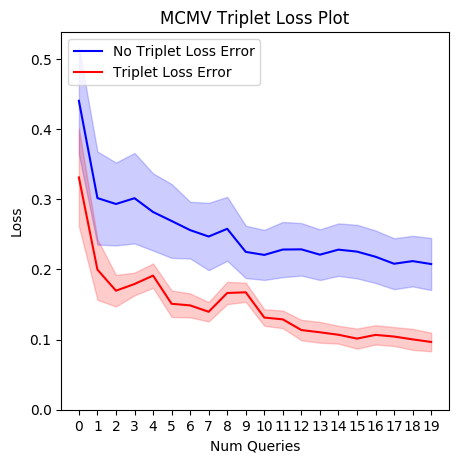

In [28]:
def triplet_vs_no_triplet(triplet_localizer_metrics, no_triplet_localizer_metrics):
    triplet_metadata_loss = []
    for trial in triplet_localizer_metrics:
        metadata_loss, localization_loss, auc_loss = trial
        triplet_metadata_loss.append(metadata_loss)

    no_triplet_metadata_loss = []
    for trial in no_triplet_localizer_metrics:
        metadata_loss, localization_loss, auc_loss = trial
        no_triplet_metadata_loss.append(metadata_loss)
    # unpack the metrics
    metadata_losses = []
    localization_losses = []
    auc_losses = []
    # calculate mean and variances
    no_triplet_variance = np.var(no_triplet_metadata_loss, axis=0)
    no_triplet_losses = np.mean(no_triplet_metadata_loss, axis=0)
    triplet_variance = np.var(triplet_metadata_loss, axis=0)
    triplet_losses = np.mean(triplet_metadata_loss, axis=0)
    # make plots for these losses
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=100)
    metadata_train = np.arange(0, np.shape(no_triplet_losses)[0])
    ax.set_title("MCMV Triplet Loss Plot")
    # plot no triplet
    ax.plot(metadata_train, no_triplet_losses, label="No Triplet Loss Error", color="blue")
    ax.fill_between(metadata_train, no_triplet_losses-no_triplet_variance, no_triplet_losses+no_triplet_variance, alpha=0.2, color="blue")
    # plot triplet
    ax.plot(metadata_train, triplet_losses, label="Triplet Loss Error", color="red")
    ax.fill_between(metadata_train, triplet_losses-triplet_variance, triplet_losses+triplet_variance, alpha=0.2, color="red")
    ax.set_xticks(list(range(0, np.shape(triplet_losses)[0])))
    ax.set_ylim(0)
    # axis labels/title
    plt.xlabel("Num Queries")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.show()
triplet_vs_no_triplet(triplet_localizer_metrics, no_triplet_localizer_metrics)

## Run localizaiton out to 100 queries for each of the models

In [15]:
                                                                                                                                                                                                                                           
def run_experiment(experiment_config, model):                                                                                                             
    which_digits = experiment_config["dataset_config"]["which_digits"]                                                                             
    component_weighting = experiment_config["dataset_config"]["component_weighting"]                                                               
    one_two_ratio = experiment_config["dataset_config"]["one_two_ratio"]                                                                           
    # make metadata oracle as trian oracle                                                                                                         
    metadata_dataset = MetadataDataset(  
            train=True, 
            which_digits=which_digits
    )
    metadata_oracle = IndexedMetadataOracle(
            metadata_dataset=metadata_dataset,
            component_weighting=component_weighting
    )
    # setup data manager
    print("Setting up data")
    triplet_train_dataset = TripletDataset(
            train=True,
            which_digits=which_digits,
            oracle=metadata_oracle,
            one_two_ratio=one_two_ratio
        ) 
    triplet_test_dataset = TripletDataset(
            train=False, 
            which_digits=which_digits, 
            oracle=metadata_oracle,  
            one_two_ratio=one_two_ratio
        )
    image_train_dataset = ImageDataset(
            train=True,
            which_digits=which_digits
        )
    image_test_dataset = ImageDataset(
            train=False,
            which_digits=which_digits
        )
    data_manager = DataManager((image_train_dataset, image_test_dataset), (triplet_train_dataset, triplet_train_dataset))
    # setup predefined oracle based on the triplets csv
    print("Setting up oracles")
    localization_metadata_oracle = MetadataOracle(metadata_dataset=metadata_dataset, component_weighting=component_weighting)
    # setup the experiment manager
    print("Setting up Experiment")
    experiment = BasicExperiment(
            data_manager=data_manager, 
            localization_oracle=localization_metadata_oracle, 
            metadata_oracle=localization_metadata_oracle, 
            experiment_config=experiment_config,
            model=model,
            run_plotting=False
        )
    # run the experiment
    print("Running Experiment")
    experiment.run()
    # return metrics
    metrics = experiment.localization_experiment_manager.localization_metrics
    return metrics

In [30]:
no_triplet_experiment_config = {
    "trials": 1,
    "epochs": 100,
    "lr": 0.001,
    "batch_size": 128,
    "trainer": "triplet",
    "localization_config": {
        "indexed": False,
        "trials": 2,
        "k": 0.5, #[0.01, 0.1, 0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 1.8, 2.0],
        "localizer_type": "MCMV",
        "num_queries": 20
    },
    "model_config": no_triplet_config["model_config"],
    "dataset_config": {
        "component_weighting": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], # weights slant and thickness
        "which_digits": [1],
        "one_two_ratio": 0.0
    }
}

triplet_experiment_config = {
    "trials": 1,
    "epochs": 100,
    "lr": 0.001,
    "batch_size": 128,
    "trainer": "triplet",
    "localization_config": {
        "indexed": False,
        "trials": 2,
        "k": 0.5, #[0.01, 0.1, 0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 1.8, 2.0],
        "localizer_type": "MCMV",
        "num_queries": 20
    },
    "model_config": triplet_config["model_config"],
    "dataset_config": {
        "component_weighting": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], # weights slant and thickness
        "which_digits": [1],
        "one_two_ratio": 0.0
    }
}
    
no_triplet_metrics = run_experiment(no_triplet_experiment_config, no_triplet_model)
triplet_metrics = run_experiment(triplet_experiment_config, triplet_model)

Setting up data
Setting up oracles
Setting up Experiment
Setting Up Logging


wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/2 [00:00<?, ?it/s]

Setting Up Model
Setting Up Trianer
Running Experiment
Running Localization
performing rollout


 50%|█████     | 1/2 [00:37<00:37, 37.32s/it]

performing rollout


100%|██████████| 2/2 [01:15<00:00, 37.61s/it]


Saving data
Setting up data
Setting up oracles
Setting up Experiment
Setting Up Logging


wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/2 [00:00<?, ?it/s]

Setting Up Model
Setting Up Trianer
Running Experiment
Running Localization
performing rollout


 50%|█████     | 1/2 [00:37<00:37, 37.72s/it]

performing rollout


100%|██████████| 2/2 [01:15<00:00, 37.85s/it]

Saving data


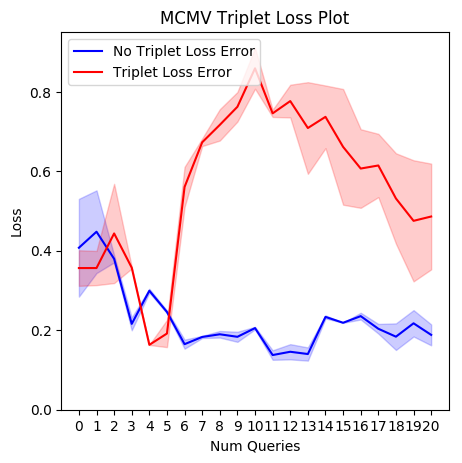

In [33]:
triplet_vs_no_triplet(triplet_metrics, no_triplet_metrics)